In [93]:
import matplotlib
import pandas as pd 
import numpy as np
import json
import os

# making plots
import matplotlib.pyplot as plt
import seaborn as sns

# math + calculations
import datetime
import math
from __future__ import division

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 100)

%config InlineBackend.figure_format = 'retina'

matplotlib.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12.0, 6.0]

# name of downloaded data folder
folderName = "facebook-mliu42" # EDIT PER PERSON
myName = "Michelle Liu"

In [217]:
# given a message.json file and the directory name it is located within, return the name and members
def getConvoNameAndMembers(messageJson):
    members = []
    for person in messageJson['participants']:
        members.append(person['name'])
    return messageJson['title'], members

# return number of words and number of non-unicode chars in a message (unicode: ', ", emojis, special characters, etc.) 
def calculateCharAndWords(messageString):
    numWords = messageString.count(" ")
    numChars = len(messageString) - messageString.count("\u") * 6 # "\n####" unicode
    return numChars, numWords

# given a message.json file, return an array of individual message objects, # sent by me
def readMessages(messageJson):
    global myName
    messages = []
    numSent = 0
    for entry in messageJson['messages']:
        if 'content' in entry:
            if entry['sender_name'] == myName:
                numSent += 1
            numChars, numWords = calculateCharAndWords(entry['content'])
            message = {
                'sender' : entry['sender_name'],
                'time' : entry['timestamp_ms'],
                'content' : entry['content'],
                'numChars' : numChars,
                'numWords' : numWords,
                # reactions, contentType
            }
            messages.append(message)
    return messages, numSent

# given path to conversation directory, process all json files
# returns single conversation object if determined interesting, else returns None
# index = 0
# def processConversation(convo_dir_path): # path: data/<myFolderName>/messages/inbox/<conversation_name>
#     global index
#     isFirst = True
#     chatName = ""
#     members = []
#     messages = []
#     numSent = 0

#     for filename in os.listdir(convo_dir_path): # iterate through all files
#         if filename[:7] == 'message': # read only message.json files
#             with open(convo_dir_path + '/' + filename) as f:
#                 messageJson = json.load(f)
#             if isFirst: # set chat name and members only once
#                 chatName, members = getConvoNameAndMembers(messageJson)
#                 isFirst = False
#             newMessages, newSent = readMessages(messageJson)
#             messages += newMessages
#             numSent += newSent

#     # check if is interesting-- <= 12 members, > 2 messages, no deleted users ("Facebook User")
#     if len(members) <= 12 and not "Facebook User" in members and len(messages) > 2:
#         index += 1
#         return {
#             "chatIndex" : index - 1,
#             "chatName" : chatName,
#             "chatMembers" : members,
#             "messages" : messages,
#             "numSentByMe" : numSent,
#         }
#     else:
#         return None
    
# attempt 2, using object for messages but df for everything else
index = 0
def processConversation(convo_dir_path): # path: data/<myFolderName>/messages/inbox/<conversation_name>
    global index
    isFirst = True
    chatName = ""
    members = []
    messages = []
    numSent = 0

    for filename in os.listdir(convo_dir_path): # iterate through all files
        if filename[:7] == 'message': # read only message.json files
            with open(convo_dir_path + '/' + filename) as f:
                messageJson = json.load(f)
            if isFirst: # set chat name and members only once
                chatName, members = getConvoNameAndMembers(messageJson)
                isFirst = False
            newMessages, newSent = readMessages(messageJson)
            messages += newMessages
            numSent += newSent

    # check if is interesting-- <= 12 members, > 2 messages, no deleted users ("Facebook User")
    if len(members) <= 12 and not "Facebook User" in members and len(messages) > 2:
        index += 1
        info = {
            "Chat ID" : index - 1,
            "Chat Name" : chatName,
            "Chat Members" : members,
            "Num Messages" : len(messages),
            "Num Sent By Me" : numSent,
        }
        messageInfo = {
            "Chat ID" : index - 1,
            "Chat Name" : chatName,
            "messages" : messages,
        }
        return info, messageInfo
    else:
        return None, None

def processAllConversations(directoryPath): # path: data/<myFolderName>/messages/inbox
    NUM_PROCESS = 100
    summaryTable = pd.DataFrame(columns=['Chat ID', 'Chat Name', 'Chat Members', 'Num Messages', 'Num Sent By Me'])
    allMessages = []
    
    index = 0
    for item in os.listdir(directoryPath): # iterate through all subdirectories
        index += 1
        if index <= NUM_PROCESS:
            convo_dir_path = directoryPath + '/' + item
            if os.path.isdir(convo_dir_path): # check is valid conversation folder
                chat_info, messages = processConversation(convo_dir_path) # returns (None, None) if not interesting
                if chat_info:
                    allMessages += [messages]
                    summaryTable = summaryTable.append(chat_info, ignore_index=True)

    return allMessages, summaryTable

In [218]:
directoryPath = 'data/' + folderName + '/messages/inbox'
allMessages, summaryTable = processAllConversations(directoryPath) # currently processing 300 for speed/testing purposes

summaryTable.sort_values('Num Messages', ascending=False)[:25]

,Chat ID,Chat Name,Chat Members,Num Messages,Num Sent By Me
15,15,Amy Hu,"[Amy Hu, Michelle Liu]",129948,61147
67,67,Eric Wang,"[Eric Wang, Michelle Liu]",60527,28586
26,26,Joseph Zhang,"[Joseph Zhang, Michelle Liu]",19368,8807
18,18,Joe Kim,"[Joe Kim, Michelle Liu]",1881,1001
21,21,Jennifer Wu,"[Jennifer Wu, Michelle Liu]",1819,831
17,17,Alex Burton,"[Alex Burton, Michelle Liu]",1642,862
38,38,Secret Santa,"[Austin Meng, Joe Kim, Amanda Zhang, Michelle ...",1342,266
41,41,Soo Kim,"[Soo Kim, Michelle Liu]",1180,586
14,14,Emily Hong,"[Emily Hong, Michelle Liu]",891,487
31,31,Music Things,"[Judy Li, Amanda Zhang, Michelle Liu, Leonardo...",722,141


In [219]:
# additional summary table processing
summaryTable['Num Sent By Them'] = summaryTable['Num Messages'] - summaryTable['Num Sent By Me']
summaryTable['Percent Sent By Me'] = summaryTable['Num Sent By Me'] / summaryTable['Num Messages']

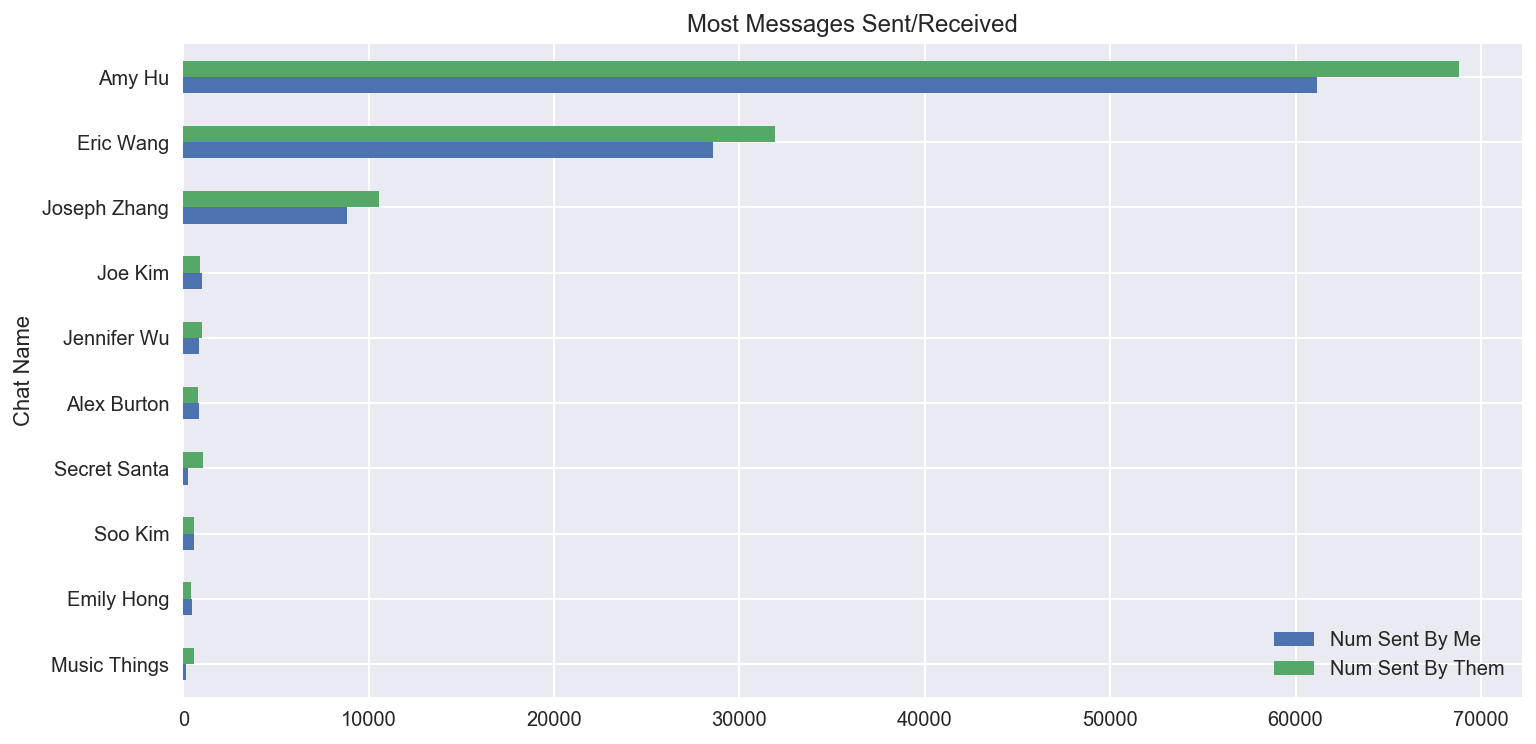

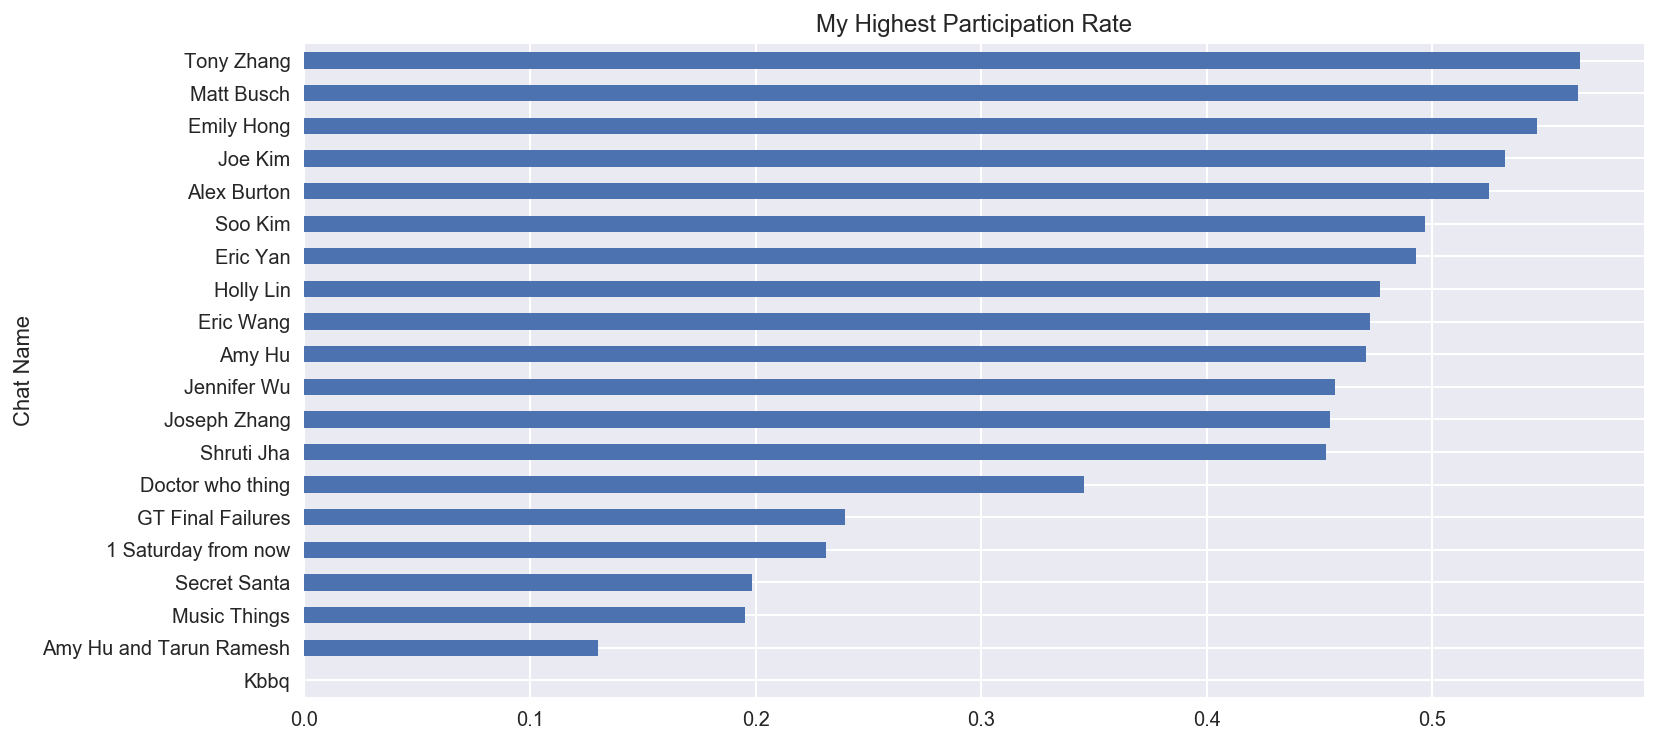

In [220]:
topTwentyMost = summaryTable.sort_values('Num Messages', ascending=False)[:20]
topTwentyMost[:10].sort_values('Num Messages', ascending=True).plot(
    x=['Chat Name'], y=['Num Sent By Me', 'Num Sent By Them'], kind="barh", title="Most Messages Sent/Received")

# Of top 20 chats, what is my highest participation? (pre-filtered by top 20 bc low # samples -> not representative)
topTwentyMost.sort_values('Percent Sent By Me', ascending=True).plot(
    x=['Chat Name'], y=['Percent Sent By Me'], kind="barh", title="My Highest Participation Rate", legend=False)

plt.show()

In [221]:
# allMessages

In [222]:
# which conversation is the most profane?
def getProfanityCount(messageString):
    count = 0
    profanityList = ["shit", "ass", "fuck", "damn", " hell"]
    for curse in profanityList:
            if curse in message['content']:
                count += 1
    return count

# which conversations are the most positive/negative?

In [224]:
# additional allMessages processing
messageStats = pd.DataFrame()

for convo in allMessages:
    wordCount = 0
    charCount = 0
    profanityCount = 0
    # other counts
    
    for message in convo['messages']:
        wordCount += message['numWords']
        charCount += message['numChars']
        profanityCount += getProfanityCount(message)

    messageStats = messageStats.append({
        'Chat ID' : convo['Chat ID'],
        'Chat Name' : convo['Chat Name'],
        'Num Messages' : len(convo['messages']),
        'Num Words' : wordCount,
        'Num Chars' : charCount,
        'Profanity' : profanityCount,
        'Profanity %': profanityCount / wordCount,
    }, ignore_index=True)

In [225]:
messageStats.sort_values(by=['Num Messages'], ascending=False)[:10].sort_values(by=['Profanity %'], ascending=False)

,Chat ID,Chat Name,Num Chars,Num Messages,Num Words,Profanity,Profanity %
26,26.0,Joseph Zhang,417586.0,19368.0,68743.0,445.0,0.006473
41,41.0,Soo Kim,21861.0,1180.0,3252.0,13.0,0.003998
67,67.0,Eric Wang,1706802.0,60527.0,297235.0,1183.0,0.003980
17,17.0,Alex Burton,42697.0,1642.0,7115.0,28.0,0.003935
15,15.0,Amy Hu,2817070.0,129948.0,451151.0,1476.0,0.003272
31,31.0,Music Things,16551.0,722.0,2690.0,8.0,0.002974
21,21.0,Jennifer Wu,34743.0,1819.0,5360.0,14.0,0.002612
38,38.0,Secret Santa,34838.0,1342.0,6011.0,15.0,0.002495
18,18.0,Joe Kim,44891.0,1881.0,7476.0,8.0,0.001070
14,14.0,Emily Hong,27343.0,891.0,4145.0,3.0,0.000724
